# Monosynaptic pair analysis
-------

Example notebook demonstrating simple functions in SynapticConn for analysing and plotting spike trains following single-unit spike-sorting in Kilosort2 and Phy2 using SpikeInterface.

In [1]:
import os
import pathlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

os.chdir('../..')
import synapticonn as synapticonn

Load spike times.

Here, we are loading a series of spike time trains exported from Kilosort 2 and Phy via the [SpikeInterface](https://github.com/SpikeInterface/spikeinterface) package. Additional file types can be used.

In [2]:
data_fpath = pathlib.Path('tests', 'BD0187_spikesorting_array.pkl')

# open pickle
all_units = np.load(data_fpath, allow_pickle=True)
all_units = all_units['spike_time_set']

# divide each row by 30000 to get time in ms
for i in all_units.keys():
    all_units[i] = (all_units[i] / 30000) * 1000
    
all_units

{np.int32(5): array([3.70000000e+01, 1.01076667e+03, 2.43186667e+03, 3.21976667e+03,
        3.99056667e+03, 5.34116667e+03, 6.99876667e+03, 8.25933333e+03,
        9.61086667e+03, 1.29460000e+04, 1.56087667e+04, 1.67817333e+04,
        1.91503000e+04, 2.04136333e+04, 2.12745333e+04, 2.32617333e+04,
        2.98763000e+04, 3.08889667e+04, 3.14764333e+04, 3.47374000e+04,
        3.88992000e+04, 4.45120333e+04, 5.40667667e+04, 5.48452000e+04,
        6.34974000e+04, 6.41382333e+04, 6.48862000e+04, 7.28615000e+04,
        7.36154667e+04, 7.43903000e+04, 7.48496000e+04, 7.84231667e+04,
        8.27839333e+04, 9.70094667e+04, 9.95140000e+04, 1.00965700e+05,
        1.03636800e+05, 1.04342000e+05, 1.05539133e+05, 1.07394433e+05,
        1.08981100e+05, 1.11468500e+05, 1.13664867e+05, 1.14589400e+05,
        1.17711800e+05, 1.21212267e+05, 1.23115000e+05, 1.25135667e+05,
        1.27302200e+05, 1.28961667e+05, 1.29825833e+05, 1.31684400e+05,
        1.32830533e+05, 1.34816567e+05, 1.38980033e

If the spike times are not in the appropriate format, then there are options available for conversions.

In [3]:
# check all plotting features --> cross-check that the kwargs works etc.

# add a marker to the plot to identify where the connections are on the CCG?
# check the spike pair checks
# add private methods into the doc strings etc. 
# add fit outputs for the report in the readme

# finalise the docs
# make tests
# pip install + finish

# any point putting the types in the parameters and also the doc strings?

# add linter etc.

# --- low priority 

# make the mode more modular??? or whatever the term is .... check this

# fix this: 
    # self.bin_size_t = self._bin_size_check(bin_size_t, max_lag_t)  --> annoying that needs to pass two params here
    # self.max_lag_t = self._max_lag_check(bin_size_t, max_lag_t)


# ---- add a dynamic plot displatch 

# synapticonn/plots/plot_manager.py

# PLOT_FUNCTIONS = {
#     "autocorrelogram": plot_acg,
#     "crosscorrelogram": plot_ccg,
#     "synaptic_strength": plot_ccg_synaptic_strength,
# }

# def dispatch_plot(plot_type, *args, **kwargs):
#     if plot_type not in PLOT_FUNCTIONS:
#         raise ValueError(f"Plot type '{plot_type}' is not supported.")
#     PLOT_FUNCTIONS[plot_type](*args, **kwargs)

# this can be used in the class like the following, so the plotting is very dynamic ... 

# synapticonn/main_class.py

# def plot(self, plot_type: str, *args, **kwargs):
#     """ General interface for plotting different types. """
#     from synapticonn.plots.plot_manager import dispatch_plot
#     dispatch_plot(plot_type, *args, **kwargs)

Initialize the object.

In [4]:
snc = synapticonn.SynaptiConn(all_units,
                              spike_id_type=np.int32,
                              method='cross-correlation',
                              time_unit='ms',
                              bin_size_t=1,
                              max_lag_t=100,
                              srate=30_000,
                              recording_length_t=600*1000)

Unit is firing across less than 20% of the recording length. This may lead to unexpected results. Please check the spike times and recording length passed to the SpikeManager object. If this is intentional, please ignore this warning.


Check the loaded spike units.

In [5]:
spk_unit_report = snc.report_spike_units()
pd.DataFrame(spk_unit_report)

,unit_id,n_spikes,firing_rate_hz
0,5,302,0.503333
1,1,1152,1.920000
2,0,918,1.530000
3,16,524,0.873333
4,17,315,0.525000
5,18,195,0.325000
6,15,192,0.320000
7,4,299,0.498333
8,3,277,0.461667


Plot the rasterplot.

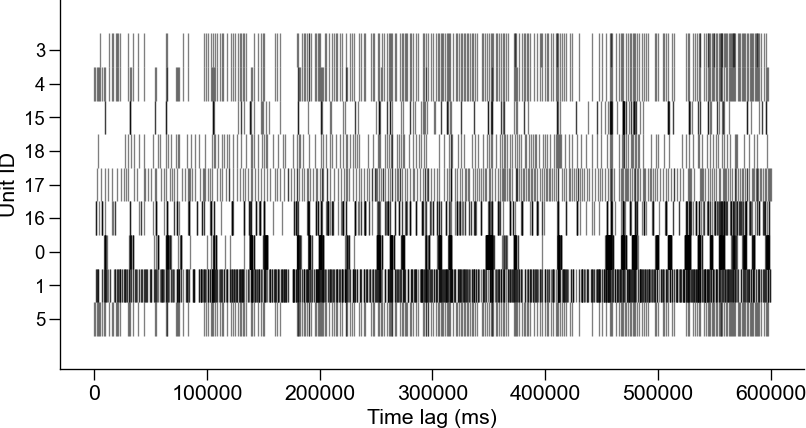

In [6]:
snc.plot_spike_train(color='black', alpha=0.5, ax = None, figsize=(10, 5))

## Spike isolation quality metrics
----

Prior to proceeding, it is important to cross-check the quality of the spike sorted neurons. 

This should be done using external spike-sorting algorithms. However, simple checks can be applied here. In future versions, these will be extended.

Metrics related to the spike quality can be found below. Notably, the autocorrelograms for each unit should also be cross-referenced prior to continuing. Low contamination (or no contamination) in the refractory periods are important for correct assesments of spike-units and their monosynaptic connections.

**NOTE** here, more simple and core metric assessments are performed. In the future, these will be extended. For further quality metrics, please see the following [code](https://github.com/SpikeInterface/spikeinterface/blob/main/src/spikeinterface/qualitymetrics/misc_metrics.py#L1183). Further, Allen Brain have core documentation which can be found [here](https://allensdk.readthedocs.io/en/latest/_static/examples/nb/ecephys_quality_metrics.html#ISI-violations) explaining some key metrics to assess spike unit quality.

In [7]:
params = {'isi_threshold_ms': 1.5,
          'min_isi_ms': 0.3,  # note :: isi min should be based on the miniimum possible refractory period (e.g. spikes removed would constitute this)
          'presence_ratio_bin_duration_sec': 60,
          'presence_ratio_mean_fr_ratio_thresh': 0.0}

qc = snc.spike_unit_quality(**params)
qc

Converting spike train and recording length to seconds for presence ratio calculation.


,isi_violations_ratio,isi_violations_count,isi_violations_of_total_spikes,presence_ratio,n_spikes,firing_rate_hz
5,0.000000,0.0,0.000000,1.0,302.0,0.503333
1,0.000754,4.0,0.003472,1.0,1152.0,1.920000
0,0.001187,4.0,0.004357,1.0,918.0,1.530000
16,0.000000,0.0,0.000000,1.0,524.0,0.873333
17,0.000000,0.0,0.000000,1.0,315.0,0.525000
18,0.000000,0.0,0.000000,1.0,195.0,0.325000
15,0.000000,0.0,0.000000,1.0,192.0,0.320000
4,0.000000,0.0,0.000000,1.0,299.0,0.498333
3,0.000000,0.0,0.000000,1.0,277.0,0.461667


Filter the spike times for 'good units' based on the quality control metrics.

These will then be used for all further processing. The spike times will be updated accordingly.

A log of the excluded units can be found and kept.

In [8]:
# query = 'presence_ratio > 0.05'
# good_units = snc.filter_spike_units(qc, query, log=True)
# good_units

Check the updates.

In [9]:
spk_unit_report = snc.report_spike_units()
pd.DataFrame(spk_unit_report)

,unit_id,n_spikes,firing_rate_hz
0,5,302,0.503333
1,1,1152,1.920000
2,0,918,1.530000
3,16,524,0.873333
4,17,315,0.525000
5,18,195,0.325000
6,15,192,0.320000
7,4,299,0.498333
8,3,277,0.461667


## Auto-correlograms
---

Compute the autocorrelogram for select unit IDs.

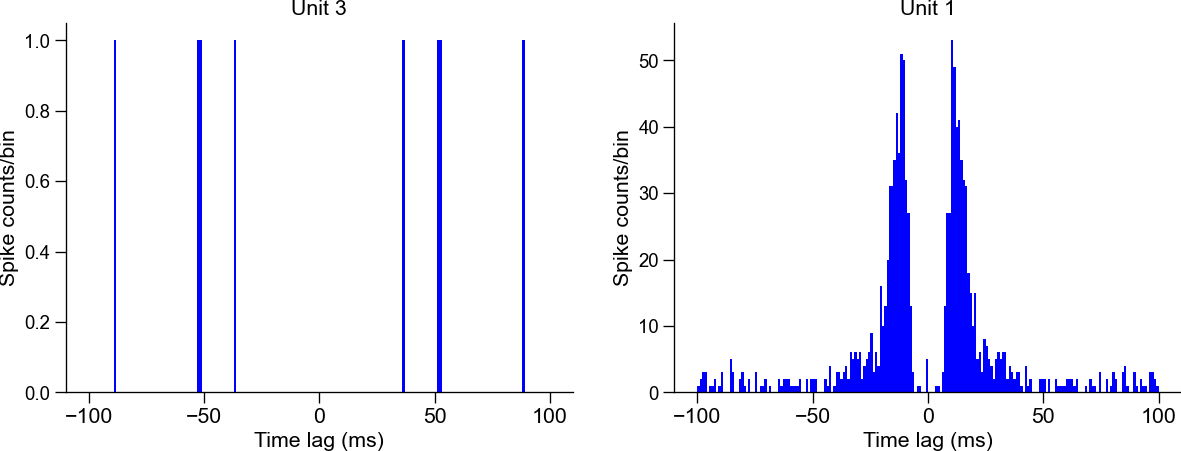

In [10]:
snc.plot_autocorrelogram(spike_units=[3,1], color='blue')

Set the bin parameters after initialization, and re-plot.

This can be used to change the binning on the plots, and max time lags.

This method is used to set the bin size and maximum lag after initialization. Please use this method with caution. Parameters should match the spike time units


Bin size set to 0.5 ms, and maximum lag set to 25 ms.


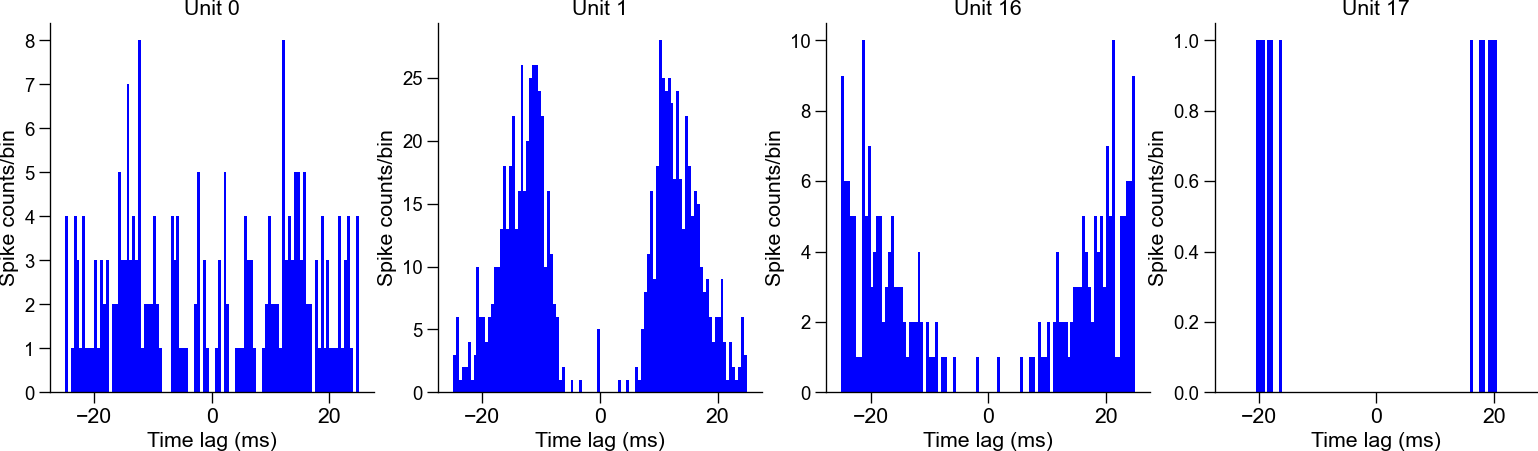

In [11]:
snc.set_bin_settings(bin_size_t=0.5, max_lag_t=25, time_unit='ms', verbose=True)
snc.plot_autocorrelogram(spike_units=[0,1,16,17], color='blue', figsize=(20,5))

## Cross-correlograms
----

Visualize cross-correlograms between pairs.

Bin size and time lag can be changed by re-setting the bins. However, for improved visualizations and reporting a smaller bin size and time lag is recommended.

In [12]:
spike_pairs = [(1,16), (1,5), (0,1), (1,16)]
snc.plot_crosscorrelogram(spike_pairs=spike_pairs, figsize=(15, 4))

## Return correlogram data
----

Next, try returning the correlogram data.

Each key in 'cross_correlations' is indexed by the unit pairs. The corresponding numbers refer to the spike counts, per bin.

Each key in 'bins' is also indexed by the unit pairs. The corresponding numbers refer to the bins edges.

In [ ]:
correlogram_data = snc.return_crosscorrelogram_data(spike_pairs=spike_pairs)
correlogram_data

{'cross_correllations': {(1,
   16): array([2, 3, 1, 2, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 2, 0, 0, 2,
         0, 2, 0, 3, 0, 0, 0, 0, 1, 1, 1, 0, 0, 2, 1, 2, 2, 1, 0, 2, 1, 1,
         0, 0, 0, 1, 1, 1, 0, 1, 0, 2, 0, 1, 2, 2, 1, 0, 1, 0, 1, 0, 1, 0,
         0, 0, 1, 1, 1, 0, 2, 0, 0, 1, 0, 1, 1, 3, 0, 0, 0, 2, 0, 0, 1, 1,
         1, 1, 1, 0, 0, 0, 1, 0, 1, 2, 0, 1]),
  (1,
   5): array([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 2, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 2, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0,
         0, 0, 0, 0, 0, 0, 2, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]),
  (0,
   1): array([2, 2, 1, 0, 2, 3, 1, 1, 3, 1, 1, 3, 1, 2, 1, 1, 3, 3, 1, 1, 2, 3,
         0, 0, 2, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 4, 2, 1, 1, 1, 3,
         2, 0, 3, 1, 2, 0, 0, 3, 1, 4, 0, 0, 1, 0, 1, 0, 3, 0, 0, 2, 1, 1,
         5, 0, 2, 0, 1, 

Check the bin settings using for correlogram generations.

In [ ]:
snc.report_correlogram_settings()

'Bin size: 0.5 ms, Max lag: 25 ms'

## Compute monosynaptic connections 
----

Compute excitatory and inhibitory monosynaptic connections between spike trains. 

This analysis was based on the following reference by Najafi et al., [here](https://www.sciencedirect.com/science/article/pii/S0896627319308487). This protocol was based on data and experimental analyses provided in the following [here](https://www.cell.com/cell-reports/fulltext/S2211-1247(23)01487-0?_returnURL=https%3A%2F%2Flinkinghub.elsevier.com%2Fretrieve%2Fpii%2FS2211124723014870%3Fshowall%3Dtrue).

> **computational strength calculations notes**

> First, compute synaptic strength for a set of neuron IDs. If a given unit consistently fires after a second unit, indicated by a peak in the CCG, there is high chance that these cells are functionally linked either directly through an excitatory synaptic connection or indirectly through a third neuron providing a common input.

> To compute synaptic strength, the firing of a single unit in a pair was jittered across a number of iterations (num_iterations) within a time range (jitter_range_ms). 
These were used to calculate a confidence interval (CI) between 1% and 99%. If the real CCG peak passed the 99% CI, the corresponding functional connection would be considered
significant and not random.

> A z-score was then performed using the following equation:

> ```Z = x_real - mean_jitter / std_jitter```

Inspect the output synaptic strength data.

Note that the output contains the following keys: 
1. ccg bins
2. ccg counts (from original spike trains)
3. ccg counts (post jitter)
4. synaptic strength
5. high confidence interval (99%), calculated on jittered ccg
6. low confidence interval (1%), calculation on jittered ccg
7. ccg counts (within jitter range window)
8. low confidence interal (1%), within jitter range window
9. high confidence interal (99%), within jitter range window

In [ ]:
synaptic_strength_data = snc.synaptic_strength(spike_pairs=spike_pairs, num_iterations=1000, jitter_range_t=10)

# isolate single neuron pair
pair = (1, 16)
synaptic_strength_data[pair]

{'ccg_bins': array([-25. , -24.5, -24. , -23.5, -23. , -22.5, -22. , -21.5, -21. ,
        -20.5, -20. , -19.5, -19. , -18.5, -18. , -17.5, -17. , -16.5,
        -16. , -15.5, -15. , -14.5, -14. , -13.5, -13. , -12.5, -12. ,
        -11.5, -11. , -10.5, -10. ,  -9.5,  -9. ,  -8.5,  -8. ,  -7.5,
         -7. ,  -6.5,  -6. ,  -5.5,  -5. ,  -4.5,  -4. ,  -3.5,  -3. ,
         -2.5,  -2. ,  -1.5,  -1. ,  -0.5,   0. ,   0.5,   1. ,   1.5,
          2. ,   2.5,   3. ,   3.5,   4. ,   4.5,   5. ,   5.5,   6. ,
          6.5,   7. ,   7.5,   8. ,   8.5,   9. ,   9.5,  10. ,  10.5,
         11. ,  11.5,  12. ,  12.5,  13. ,  13.5,  14. ,  14.5,  15. ,
         15.5,  16. ,  16.5,  17. ,  17.5,  18. ,  18.5,  19. ,  19.5,
         20. ,  20.5,  21. ,  21.5,  22. ,  22.5,  23. ,  23.5,  24. ,
         24.5,  25. ]),
 'original_crosscorr_counts': array([2, 3, 1, 2, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 2, 0, 0, 2,
        0, 2, 0, 3, 0, 0, 0, 0, 1, 1, 1, 0, 0, 2, 1, 2, 2, 1, 0, 2, 1, 1,
      

Check the synaptic strength data for a select pair.

This can be done automatically by plotting the original ccg, and the z-scored value.

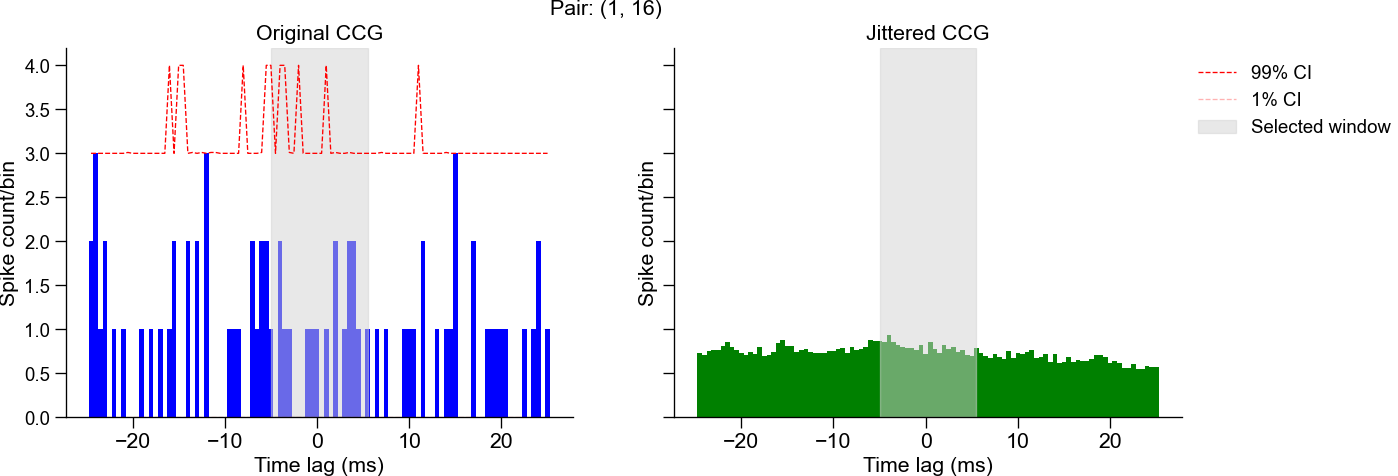

In [ ]:
snc.plot_synaptic_strength(spike_pair = pair)

**Next, check the connection type.** 

Here, we can perform a putative detection using the z-score (synaptic strength) output.

Thresholds should be set as > 5 for excitatory-connections, or inhibitory connections as < -5 based on the reference protocol.

In [ ]:
exc_connection_types = snc.monosynaptic_connection_types(synaptic_strength_threshold = 5)
exc_df = pd.DataFrame(exc_connection_types).T
exc_df

putative_exc_connection_type
1 16                    undefined
  5                     undefined
0 1                     undefined

Output a features dataframe containing selected spike pair connections and associated ccg features.

These can be used to provide simple information on the quality of the CCG, and associated connection types.

In [ ]:
synaptic_features = snc.monosynaptic_connection_features()
synaptic_features_df = pd.DataFrame(synaptic_features).T
synaptic_features_df

synaptic_strength  ccg_peak_time_ms  ccg_peak_count_per_bin  \
1 16           1.373045             -24.5                     3.0   
  5            4.044849             -15.5                     2.0   
0 1            2.619240               8.0                     5.0   

      bootstrap_std    ccg_cv  
1 16       0.081251  1.070894  
  5        0.044871  2.637893  
0 1        0.117772  0.914768

The output dataframes can be merged for simplicity and further analyses.

In [ ]:
merged_df = exc_df.join(synaptic_features_df)
merged_df

putative_exc_connection_type  synaptic_strength  ccg_peak_time_ms  \
1 16                    undefined           1.373045             -24.5   
  5                     undefined           4.044849             -15.5   
0 1                     undefined           2.619240               8.0   

      ccg_peak_count_per_bin  bootstrap_std    ccg_cv  
1 16                     3.0       0.081251  1.070894  
  5                      2.0       0.044871  2.637893  
0 1                      5.0       0.117772  0.914768

## Infer monosynaptic connections & report
-----

Alternatively, there is a simpler method to compute monosynaptic connections. Simply, monosynaptic connections can be inferred in one line. This combines the period methods.

For feature extractions, this can be performed separately and combined.

In [ ]:
connection_data = snc.fit(spike_pairs, synaptic_strength_threshold=5, num_iterations=1000)
pd.DataFrame(connection_data).T

putative_exc_connection_type synaptic_strength ccg_peak_time_ms  \
1 16                    undefined          1.373045            -24.5   
  5                     undefined          4.044849            -15.5   
0 1                     undefined           2.61924              8.0   

     ccg_peak_count_per_bin bootstrap_std    ccg_cv  
1 16                      3      0.082768  1.070894  
  5                       2      0.044857  2.637893  
0 1                       5       0.11433  0.914768

Summarize the data outputs using report. This is a convience method that calls a series of methods: 
- fit()
- print_results()

Each of these methods can be used individually.

In [ ]:
snc.report(spike_pairs, synaptic_strength_threshold=5, num_iterations=1000)

                                                                                                  
                              SYNAPTICONN - MONOSYNAPTIC CONNECTIONS                              
                                                                                                  
                             ----------------------------------------                             
                                      Recording Parameters:                                       
                                                                                                  
                                     Sampling rate: 30000 Hz                                      
                                  Recording length: 600000.00 ms                                  
                                                                                                  
                               Cross-Correlation Method Parameters:                               
          

Visualize the connection type.

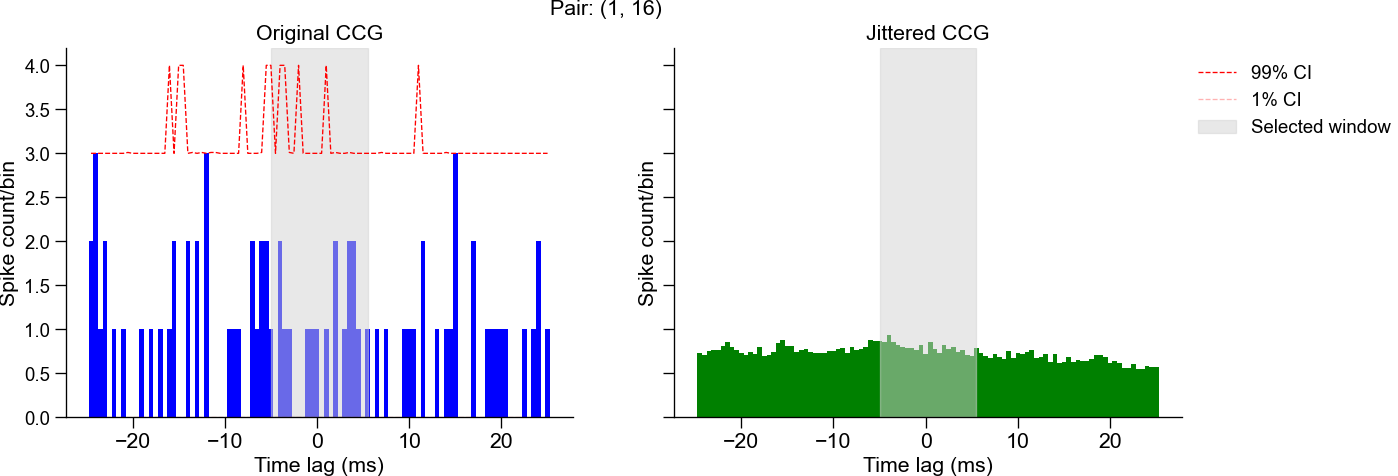

In [ ]:
snc.plot_synaptic_strength(spike_pair = (1, 16))

## Monosynaptic connection quality control
------

Next, check the results. It is important to ensure the connections are truely monosynaptic, and not polysynaptic or simply a byproduct of poorly isolated spike-units.

To do so, there are several in-built modules to check the quality of the outputs. These are based on the type of connections and time-lag threshold estimates.

**Acceptance criteria**
1. Excitatory connections between cells located near each other should occur within 2 ms.
2. The monosynaptic peak should also be shaped as a double expontential function with a fast rise and a slower decay. Inhibitory connections have a slower decay, and should be factored into your QC metrics.

**Rejection criteria**
1. If the CCG shows a maintained refractory period, it suggests that the spikes should have been merged in the spike-sorting process. Hence, if a monosynaptic peak is seen, then it is likely because it is the same neuron which has not been correctly merged.
2. If the CCG peak coincides with the ACG peak (usually slower than 2 ms), the unit likely should have been merged in the spike sorting process, of the cell-pair is probably contaminated with a 3rd pair.
3. A broad centrally aligned CCG peak indicates common drive, and therefore should be rejected. This is often seen when comparing two cells located at different shanks (> hundreds of um apart). This can be difficult to differentiate.

Select units can be rejected.

In [ ]:
# add in colors for the different connection types ++ also highlight those excluded???

## TO DO:
-----

- Spike train plots

- Make a Docker container

- Make a .yml file for this also --> conda etc.

- Proper test units 

- Fix the stupid re-cals when imported 


--------


- Check why the QCs are so bad on the other recordings?

- Clear log for when re-initializing new object?? Or atleast warn of this?

- See the test data --> check the incasing here

- There are a number of ways to validate the significance of the connections ... build these in??? Poission distributions??

- Make another notebook and check on a small subset of data

- Start writing up documents for github

- Improve the README ...

- Can possibly perform a cross-correlation analysis also on the spike trains ... see Elephant package for this

- Map the spike positions using the outputs from SpikeInterface and probe interface??? Make functional assessments between the two

- Ensure the variable naming is clear for all

- Can you integrate it to map the connections between cells?

- Make a JSON output --> export module for the dataset! This will be then easier to load --> make another option to batch-process and visualize multiple datasets etc. etc.

- Make an option to add new data -- therefore clearing the previous data here

- Check this analysis with a DANDI dataset

- Make a simulation model for ccgs and times etc. etc. to test these parameters

- Test units

- Style is not being fitted globally --> the decorator is useless?

- Document all the steps in place to check this all out ...

- Build a core object which allows for batch-processing, but also adds in the srates etc. of the recordings

- Option to cross-check with the distances???

- Fix the CCG plots